# "Um exercício de Machine Learning usando a base de dados Restaurant Revenue Prediction do Kaggle"

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.model_selection import GridSearchCV

In [2]:
train = pd.read_csv("train.csv")

In [3]:
test = pd.read_csv("test.csv")

Nesse trabalho, propõe-se explorar as diferenças de Revenue em restaurantes da Turquia ao utilizar modelos estatísticos para prever possíveis revenues de outros restaurantes a partir das características e estimativas desses. O train set do problema tem seu revenue bem definido junto às características e, portanto, modelos supervisionados serão preferíveis.

In [4]:
train

,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,...,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
0,0,07/17/1999,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,...,3.0,5,3,4,5,5,4,3,4,5653753.0
1,1,02/14/2008,Ankara,Big Cities,FC,4,5.0,4.0,4.0,1,...,3.0,0,0,0,0,0,0,0,0,6923131.0
2,2,03/09/2013,Diyarbakır,Other,IL,2,4.0,2.0,5.0,2,...,3.0,0,0,0,0,0,0,0,0,2055379.0
3,3,02/02/2012,Tokat,Other,IL,6,4.5,6.0,6.0,4,...,7.5,25,12,10,6,18,12,12,6,2675511.0
4,4,05/09/2009,Gaziantep,Other,IL,3,4.0,3.0,4.0,2,...,3.0,5,1,3,2,3,4,3,3,4316715.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,132,06/25/2008,Trabzon,Other,FC,2,3.0,3.0,5.0,4,...,3.0,0,0,0,0,0,0,0,0,5787594.0
133,133,10/12/2006,İzmir,Big Cities,FC,4,5.0,4.0,4.0,2,...,3.0,0,0,0,0,0,0,0,0,9262754.0
134,134,07/08/2006,Kayseri,Other,FC,3,4.0,4.0,4.0,2,...,3.0,0,0,0,0,0,0,0,0,2544857.0
135,135,10/29/2010,İstanbul,Big Cities,FC,4,5.0,4.0,5.0,2,...,3.0,0,0,0,0,0,0,0,0,7217634.0


## Lidando com os Dados e Análise Descritiva

O banco de dados fornecerá o ID do restaurante de acordo com o próprio banco de dados, a data de abertura do restaurante, a cidade da Turquia em que o restaurante está localizado, se a cidade é considerada grande ou não, o tipo de alimentação e de restaurante e variáveis não denominadas relacionadas a população local, desempenho econômico local, condições geográficas e relacionados. Dessa forma, inicia-se sua exploração:

In [5]:
# Primeiramente, quanto a variável de data de abertura, 
# aparenta ser melhor para se quantificar o tempo de abertura do restaurante,
# transformando a variável de data em uma variável discreta inteira:
dic = {}
n=0
for k in train["Open Date"]:
    train["Open Date"][n] = float(2014 - int(k[-4:]))
    n+=1
n=0
for k in test["Open Date"]:
    test["Open Date"][n] = float(2014 - int(k[-4:]))
    n+=1
train.rename(columns = {"Open Date": "age"}, inplace=True)
test.rename(columns = {"Open Date": "age"}, inplace=True)

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [6]:
# Em segundo lugar, para estimações futuras, é mais interessante que
# as variáveis categóricas apresentem-se em formato de Dummies.
# No primeiro caso, cria-se uma Dummie para cidades grandes, pois caso seja 0 será outro.
# No segundo caso, criam-se dummies para Food Court, Inline e Drive-Thru
encoded_columns = pd.get_dummies(train["City Group"])
train=train.join(encoded_columns["Big Cities"])

encoded_columns = pd.get_dummies(test["City Group"])
test=test.join(encoded_columns["Big Cities"])

encoded_columns = pd.get_dummies(train["Type"])
train=train.join(encoded_columns)

encoded_columns = pd.get_dummies(test["Type"])
test=test.join(encoded_columns).drop(columns=["MB"])

Text(0.5, 1.0, 'Distribution of Revenue')

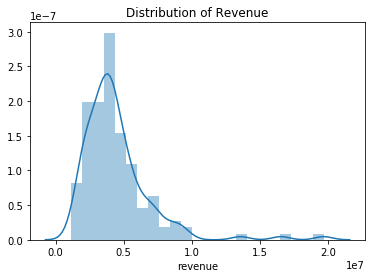

In [7]:
# Em seguida, inicia-se a análise descritiva de dados.
# Primeiramente, visa-se observar o comportamento do Revenue.
x = train["revenue"]
sns.distplot(x)
plt.title("Distribution of Revenue")

Percebemos pelo gráfico que, assim como o esperado, a maior parte dos restaurantes tem rendimentos próximos, com alguns distanto ao ter rendas baixas ou altas, não sendo um indicativo da lucratividade.

Text(0.5, 1.0, 'Big Cities')

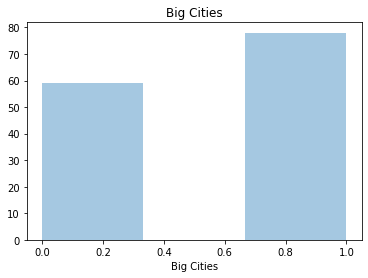

In [8]:
# Em seguida, observemos de que forma revenue está distribuída
# conforme as dummies criadas anteriormente.
y=train["Big Cities"]
sns.distplot(y, kde=False)
plt.title("Big Cities")

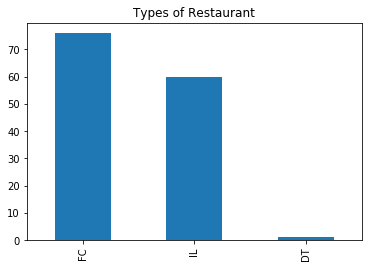

In [9]:
train["Type"].value_counts().plot(kind="bar")
plt.title("Types of Restaurant")
y=train["Big Cities"]

Text(0, 0.5, 'Revenue')

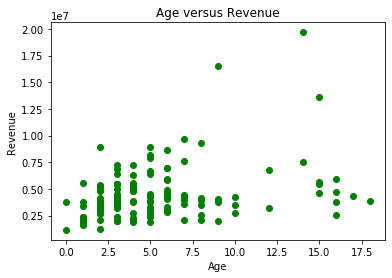

In [10]:
# Junto a isso, mostra-se interessante observar como se
x=train["age"]
y=train["revenue"]
plt.plot(x,y,"go")
plt.title("Age versus Revenue")
plt.xlabel("Age")
plt.ylabel("Revenue")

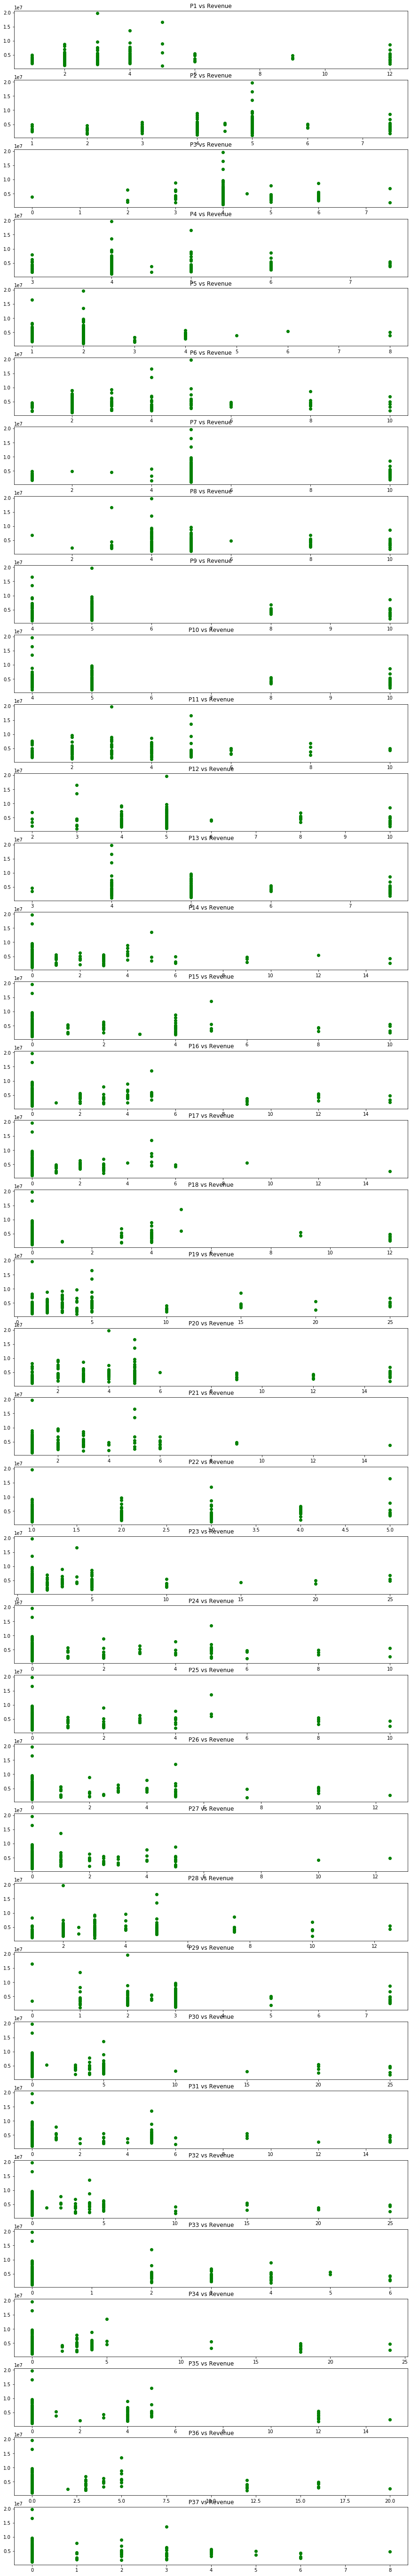

In [11]:
#Tratemos aqui do gráfico de cada uma das outras variáveis pelo Revenue.
x = train.drop(columns=["Id","age","City","City Group","Type","Big Cities","DT","FC","IL","revenue"])
y =train["revenue"]
fig, axs = plt.subplots(37, figsize=(15,100),sharey=True)
n=0
for col in x.columns:
    axs[n].plot(x[col],y,"go")
    axs[n].set_title(str(col)+" vs Revenue")
    n+=1

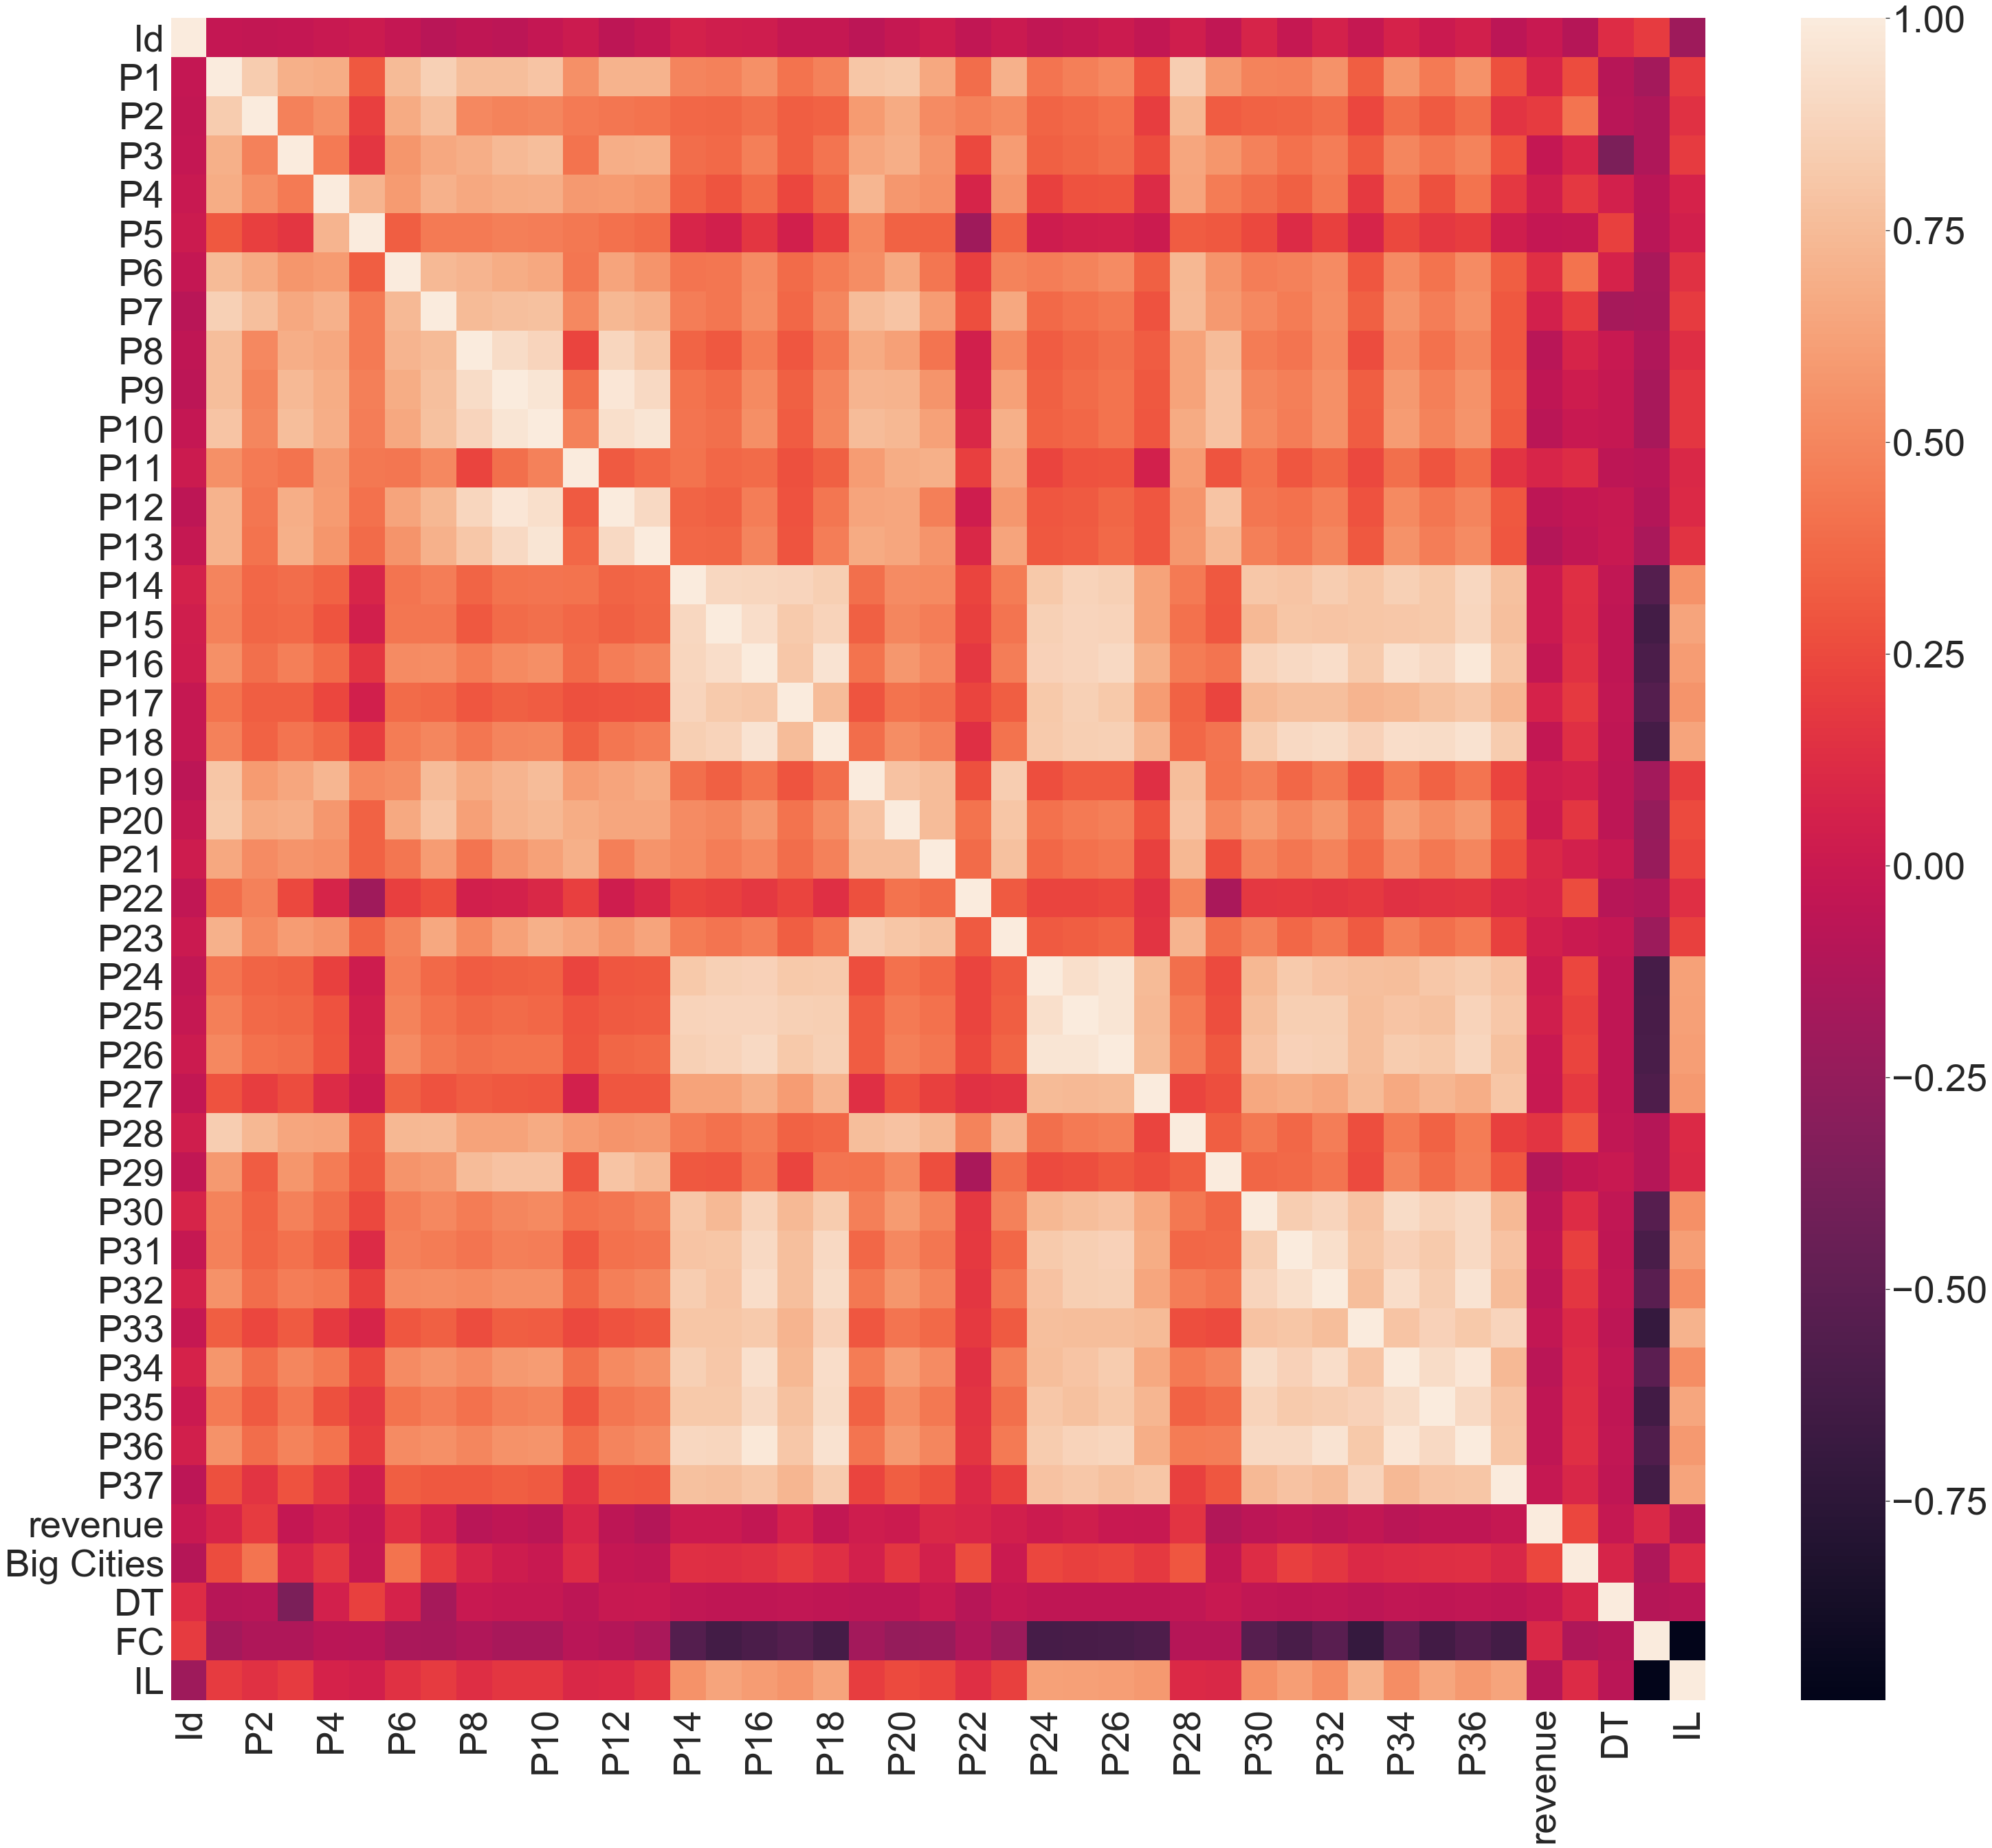

In [16]:
# Em seguida, visa-se observar a correlação entre as variáveis em geral.
# Para isso, tendo em visão tornar a análise o mais acessível, utiliza-se um Heat Map.
plt.figure(figsize=(50,45))
sns.heatmap(train.corr())
sns.set(font_scale=10)
# Uma tendência muito importante observada visualmente é que, individualmente, 
# todas as variáveis aparentam estar pouco relacionadas com revenue.

## Estimando um modelo linear em múltiplas variáveis

Inicialmente, propõe-se a utilização de um modelo linear para realizar a estimativa. Todavia, espera-se que essa estimativa original dificilmente seja adequada, visto que o train set apresenta apenas 137 observações e mais de 40 variáveis explicativas.

In [11]:
y = train["revenue"]
x = train.drop(columns=["Id","City","City Group","Type","revenue"])
x = sm.add_constant(x)
m = sm.OLS(y,x.astype(float))
est = m.fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.354
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     1.271
Date:                Thu, 04 Nov 2021   Prob (F-statistic):              0.170
Time:                        23:59:56   Log-Likelihood:                -2186.3
No. Observations:                 137   AIC:                             4457.
Df Residuals:                      95   BIC:                             4579.
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.191e+06    3.3e+06      1.269      0.2

Assim como esperado, as variáveis não se provaram tão significativas e o score $R^2$ ainda menos. Apenas as variáveis FC, P26, P20, P8 e Age se provaram significativas a um nível de 10% e apenas P8 e Age a um nível de 5%. Além disso, o $R^2$ obtido de 0,354, já diminuto, prova-se ainda menor quando o consideramos de forma ajustada, apenas de 0,076, análise complementar válida dada a quantidade de variáveis utilizadas no processo.

## Testando outros modelos para realizar a previsão

Inicialmente, propõe-se a utilização de métodos de regularização para manter o modelo linear, mas tentar otimizar os resultados antes obtidos. Para isso, serão utilizados o modelo LASSO, o modelo Ridge e o modelo Elastic-Net.

In [12]:
y = train["revenue"]
x = train.drop(columns=["Id","City","City Group","Type","revenue"])
par = {
    'alpha' : [.01, .1, .25, .5, .75, 1, 5, 10],
    'fit_intercept' : [True, False],
    'normalize' : [True,False],
    'tol' : [0.001, 0.005, 0.01, 0.05, 0.1],
}

las=Lasso()
grid = GridSearchCV(las, par, scoring='r2', n_jobs=-1)
grid.fit(x,y)
print(grid.best_params_)
print(grid.best_score_)

{'alpha': 10, 'fit_intercept': False, 'normalize': True, 'tol': 0.1}
-0.4260694167871029


In [13]:
y = train["revenue"]
x = train.drop(columns=["Id","City","City Group","Type","revenue"])
par = {
    'alpha' : [.01, .1, .25, .5, .75, 1, 5, 10],
    'fit_intercept' : [True, False],
    'normalize' : [True,False],
    'tol' : [0.001, 0.005, 0.01, 0.05, 0.1],
}

rid=Ridge()
grid = GridSearchCV(rid, par, scoring='r2', n_jobs=-1)
grid.fit(x,y)
print(grid.best_params_)
print(grid.best_score_)

{'alpha': 5, 'fit_intercept': True, 'normalize': True, 'tol': 0.001}
0.023808300504311774


In [14]:
y = train["revenue"]
x = train.drop(columns=["Id","City","City Group","Type","revenue"])
par = {
    'alpha' : [.01, .1, .25, .5, .75, 1, 5, 10],
    'fit_intercept' : [True, False],
    'normalize' : [True,False],
    'tol' : [0.001, 0.005, 0.01, 0.05, 0.1],
}

ela=ElasticNet()
grid = GridSearchCV(ela, par, scoring='r2', n_jobs=-1)
grid.fit(x,y)
print(grid.best_params_)
print(grid.best_score_)

{'alpha': 0.1, 'fit_intercept': True, 'normalize': True, 'tol': 0.05}
0.02230544354633106


A partir dos resultados obtidos, percebe-se que o modelo LASSO apresenta a pior performance, enquanto os modelos de Elastic Nets e Ridge apresentam desempenhos bem semelhantes. Portanto, utilizaremos o modelo Ridge para realizar a estimativa do nosso test set.

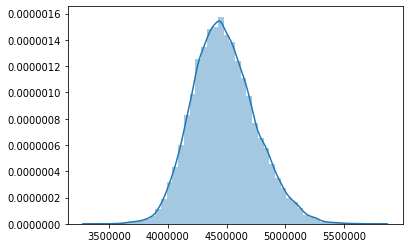

In [15]:
y = train["revenue"]
x = train.drop(columns=["Id","City","City Group","Type","revenue"])
X = test.drop(columns=["Id","City","City Group","Type"])
rid=Ridge(alpha=5,fit_intercept=True, normalize=True, tol =0.001)
rid.fit(x,y)
yhat = rid.predict(X)
sns.distplot(yhat)